<a href="https://colab.research.google.com/github/Andrius-M/RE-price-prediction/blob/master/Final_RE_Price_Prediction_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ABOUT**
This is Machine Learning project of predicting RE prices (flats) in Lithuania capital Vilnius. 
Data used for this project was taken from one of RE advertisments portals for education purpose. 
9286 entries were used for training set
2734 entries were used for testing set

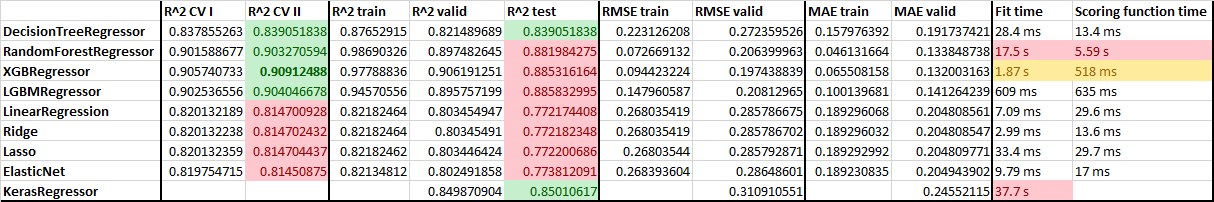

# Libraries installation and import

In [ ]:
!pip install toai
!pip install category_encoders
!pip install pdpbox
!pip install scikit-misc

In [12]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from toai.imports import *
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from pdpbox import pdp
from plotnine import *

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor
from keras.regularizers import l2

import category_encoders as ce

/usr/local/lib/python3.6/dist-packages/toai/imports.py:79: UserWarning: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
  warnings.warn(str(error))


# DataSet import from Google Drive

In [4]:
# How to import files and run in google colab https://www.youtube.com/watch?v=oqMImCeXi6o
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [5]:
# Autentification with your google account
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
# Access file from google drive
downloaded = drive.CreateFile({'id':'1LhPLaSbQ96B2NQKiI5q5wDIyat_ht84s'}) # replace the id with id of file you want to access
downloaded.GetContentFile('RE_Final_Project.xlsx') 

In [7]:
file_name = 'RE_Final_Project.xlsx'
df =  pd.read_excel(file_name)

# DataSet preparation, feature engineering, preprocessing

In [69]:
dfRF = df.copy()

dfRF = dfRF[
    (dfRF["nr_floors"] < 30)
    & (dfRF["space_sq_m"] < 500.00)
    & (dfRF["nr_rooms"] < 15)
    & (dfRF["total_price"] > 10000)
    & (dfRF["total_price"] < 1000000)
]

dfRF["log_price"] = np.log(dfRF["total_price"])

dfRF["district_counts"] = dfRF.district.groupby(dfRF.district).transform("count")
dfRF["street_counts"] = dfRF.street.groupby(dfRF.street).transform("count")

dfRF["district_street"] = dfRF["district"] + "_" + dfRF["street"]
label_enc = LabelEncoder()
dfRF = dfRF.assign(district_street_cat=label_enc.fit_transform(dfRF["district_street"]))

dfRF["year_2000-2021"] = dfRF["year"].apply(
    lambda x: 1 if x >= 2000 else 0
)
dfRF["year_1980-2000"] = dfRF["year"].apply(
    lambda x: 1 if (x >= 1980) & (x < 2000) else 0
)
dfRF["year_1960-1980"] = dfRF["year"].apply(
    lambda x: 1 if (x >= 1960) & (x < 1980) else 0
)
dfRF["year_1940-1960"] = dfRF["year"].apply(
    lambda x: 1 if (x >= 1940) & (x < 1960) else 0
)
dfRF["year_1800-1940"] = dfRF["year"].apply(
    lambda x: 1 if x < 1940 else 0
)

In [70]:
X_train = dfRF[dfRF["type"] == 1]
y_train = X_train.log_price

X_valid = dfRF[dfRF["type"] == 5]
y_valid = X_valid.log_price

In [71]:
cat_features = ["district", "street", "district_street"]

target_enc = ce.TargetEncoder(cols=cat_features)
target_enc.fit(X_train[cat_features], X_train["log_price"])

X_train = X_train.join(
    target_enc.transform(X_train[cat_features]).add_suffix("_target")
)
X_valid = X_valid.join(
    target_enc.transform(X_valid[cat_features]).add_suffix("_target")
)

In [72]:
X_train = X_train[
    [
        "year",
        "nr_rooms",
        "space_sq_m",
        "floor",
        "nr_floors",
        "district_target",
        "street_target",
        "district_street_target",
        "district_street_cat",
        "district_counts",
        "street_counts",
        "year_2000-2021",
        #"year_1980-2000",
        #"year_1960-1980",
        #"year_1940-1960",
        #"year_1800-1940",
    ]
]
X_valid = X_valid[
    [
        "year",
        "nr_rooms",
        "space_sq_m",
        "floor",
        "nr_floors",
        "district_target",
        "street_target",
        "district_street_target",
        "district_street_cat",
        "district_counts",
        "street_counts",
        "year_2000-2021",
        #"year_1980-2000",
        #"year_1960-1980",
        #"year_1940-1960",
        #"year_1800-1940",
    ]
]

In [115]:
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)
X_train

(9286, 12) (2734, 12) (9286,) (2734,)


,year,nr_rooms,space_sq_m,floor,nr_floors,district_target,street_target,district_street_target,district_street_cat,district_counts,street_counts,year_2000-2021
0,1940,1,32.26,1,1,11.578536,11.309201,11.309201,3,694,107,0
1,1964,3,58.75,5,5,11.578536,11.309201,11.309201,3,694,107,0
2,1967,3,71.86,5,5,11.578536,11.309201,11.309201,3,694,107,0
3,2020,2,40.19,3,3,11.578536,11.309201,11.309201,3,694,107,1
4,2020,2,49.68,3,3,11.578536,11.309201,11.309201,3,694,107,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9324,1981,2,35.00,5,5,11.435473,11.029247,10.936739,1023,629,43,0
9325,1969,1,27.60,6,9,11.435473,11.015869,11.282959,1022,629,207,0
9326,1964,3,61.41,2,5,11.435473,11.015869,11.282959,1022,629,207,0
9327,1968,2,47.00,2,5,11.435473,11.015869,11.282959,1022,629,207,0


# Exploratory data analysis


In [41]:
data = dfRF[
    [
        "year",
        "nr_rooms",
        "space_sq_m",
        "floor",
        "nr_floors",
        "district",
        "street",
        "total_price",
    ]
]

lb_district = LabelEncoder()
data["district_code"] = lb_district.fit_transform(data["district"])

lb_street = LabelEncoder()
data["street_code"] = lb_street.fit_transform(data["street"])

data = data[
    [
        "year",
        "nr_rooms",
        "space_sq_m",
        "floor",
        "nr_floors",
        "district_code",
        "street_code",
        "total_price",
    ]
]

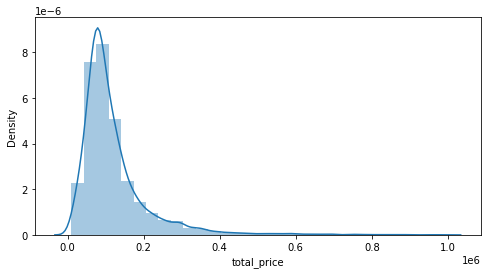

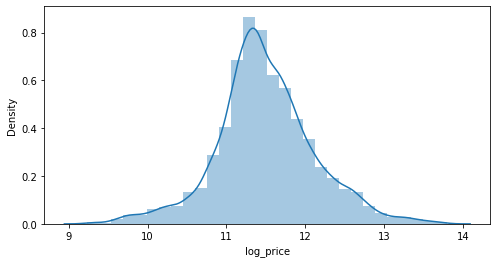

In [42]:
plt.figure(figsize=(8, 4)), 
sns.distplot(dfRF['total_price'],bins=30),
plt.figure(figsize=(8, 4)),
sns.distplot(dfRF['log_price'],bins=30)

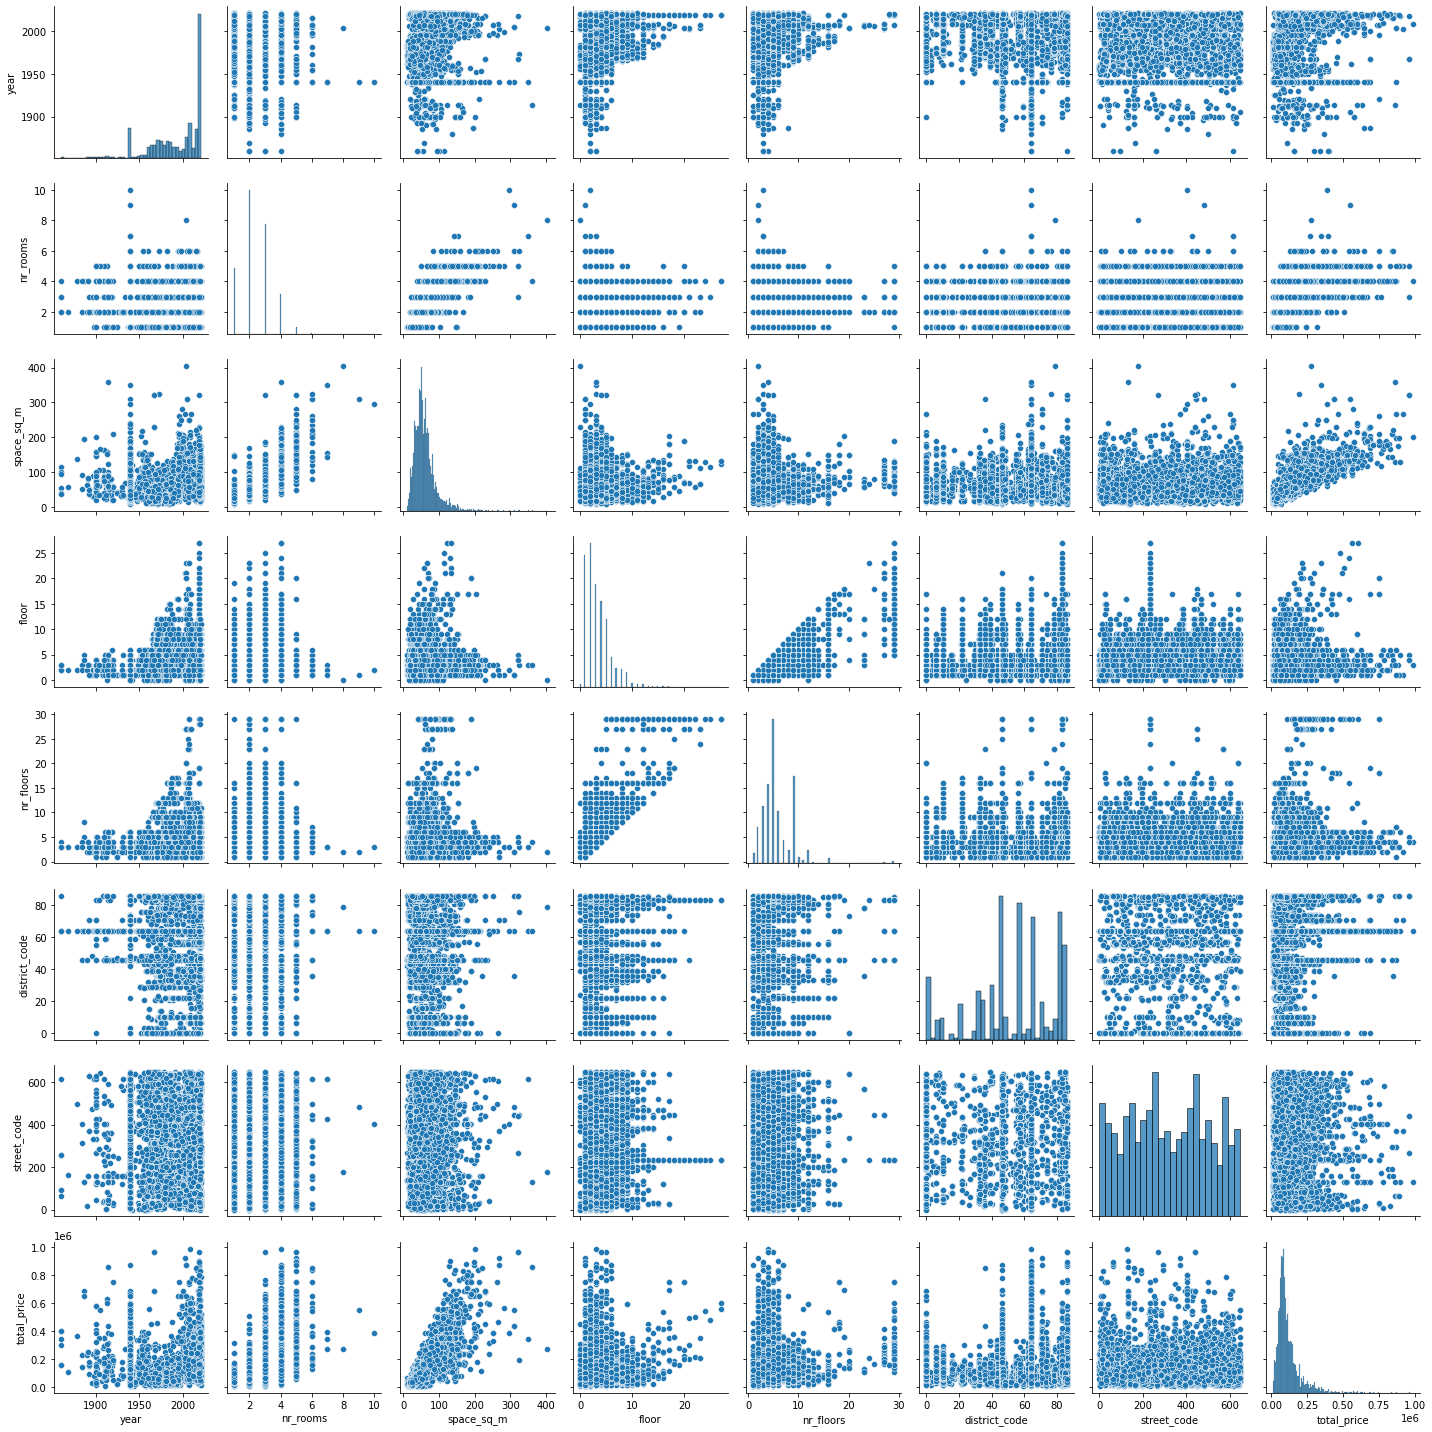

In [43]:
# Calculate and show pairplot
sns.pairplot(data, height=2.5)
plt.tight_layout()

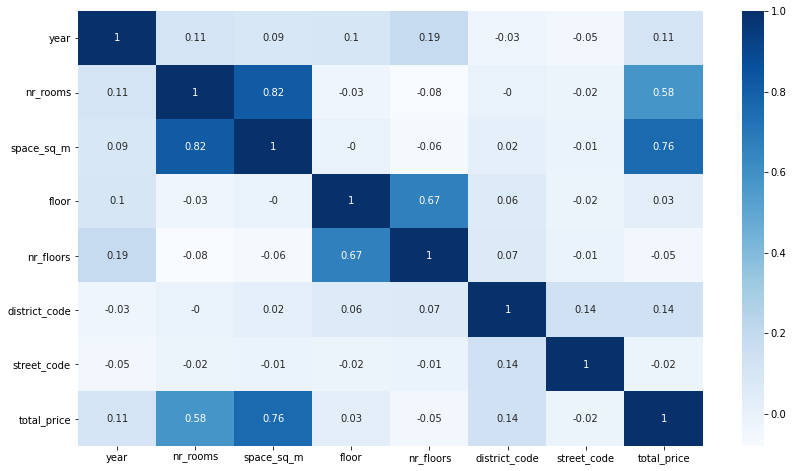

In [44]:
plt.figure(figsize=(14, 8))
corr_matrix = data.corr().round(2)
sns.heatmap(data=corr_matrix, cmap="Blues", annot=True)

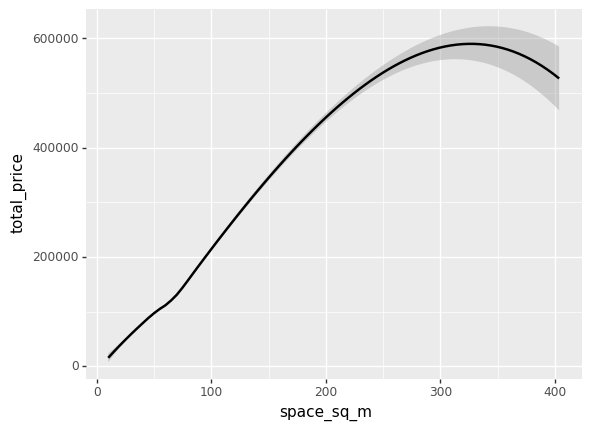

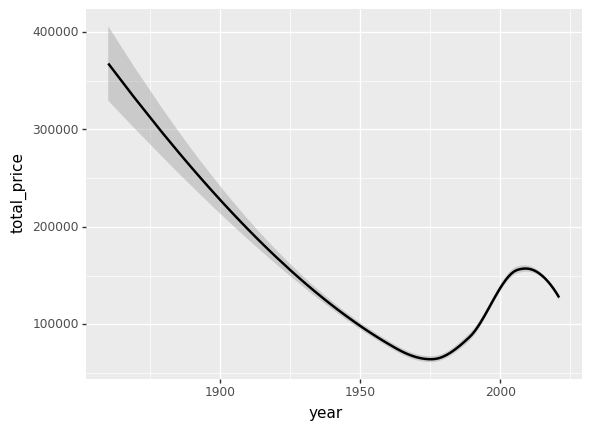

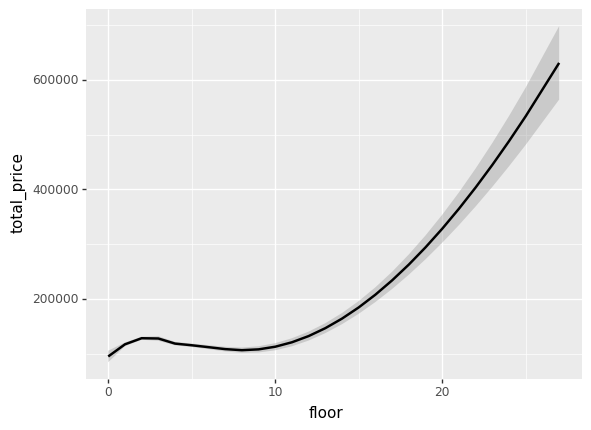

(<ggplot: (8732289261979)>,
 <ggplot: (8732289151962)>,
 <ggplot: (8732289226262)>)

In [19]:
ggplot(data, aes('space_sq_m', 'total_price'))+stat_smooth(se=True, method='loess'), 
ggplot(data, aes('year', 'total_price'))+stat_smooth(se=True, method='loess'), 
ggplot(data, aes('floor', 'total_price'))+stat_smooth(se=True, method='loess')

Text(0, 0.5, 'price')

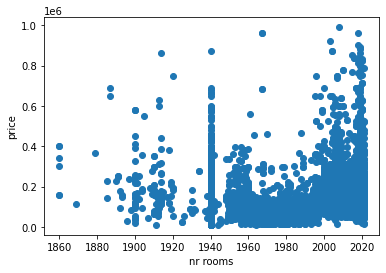

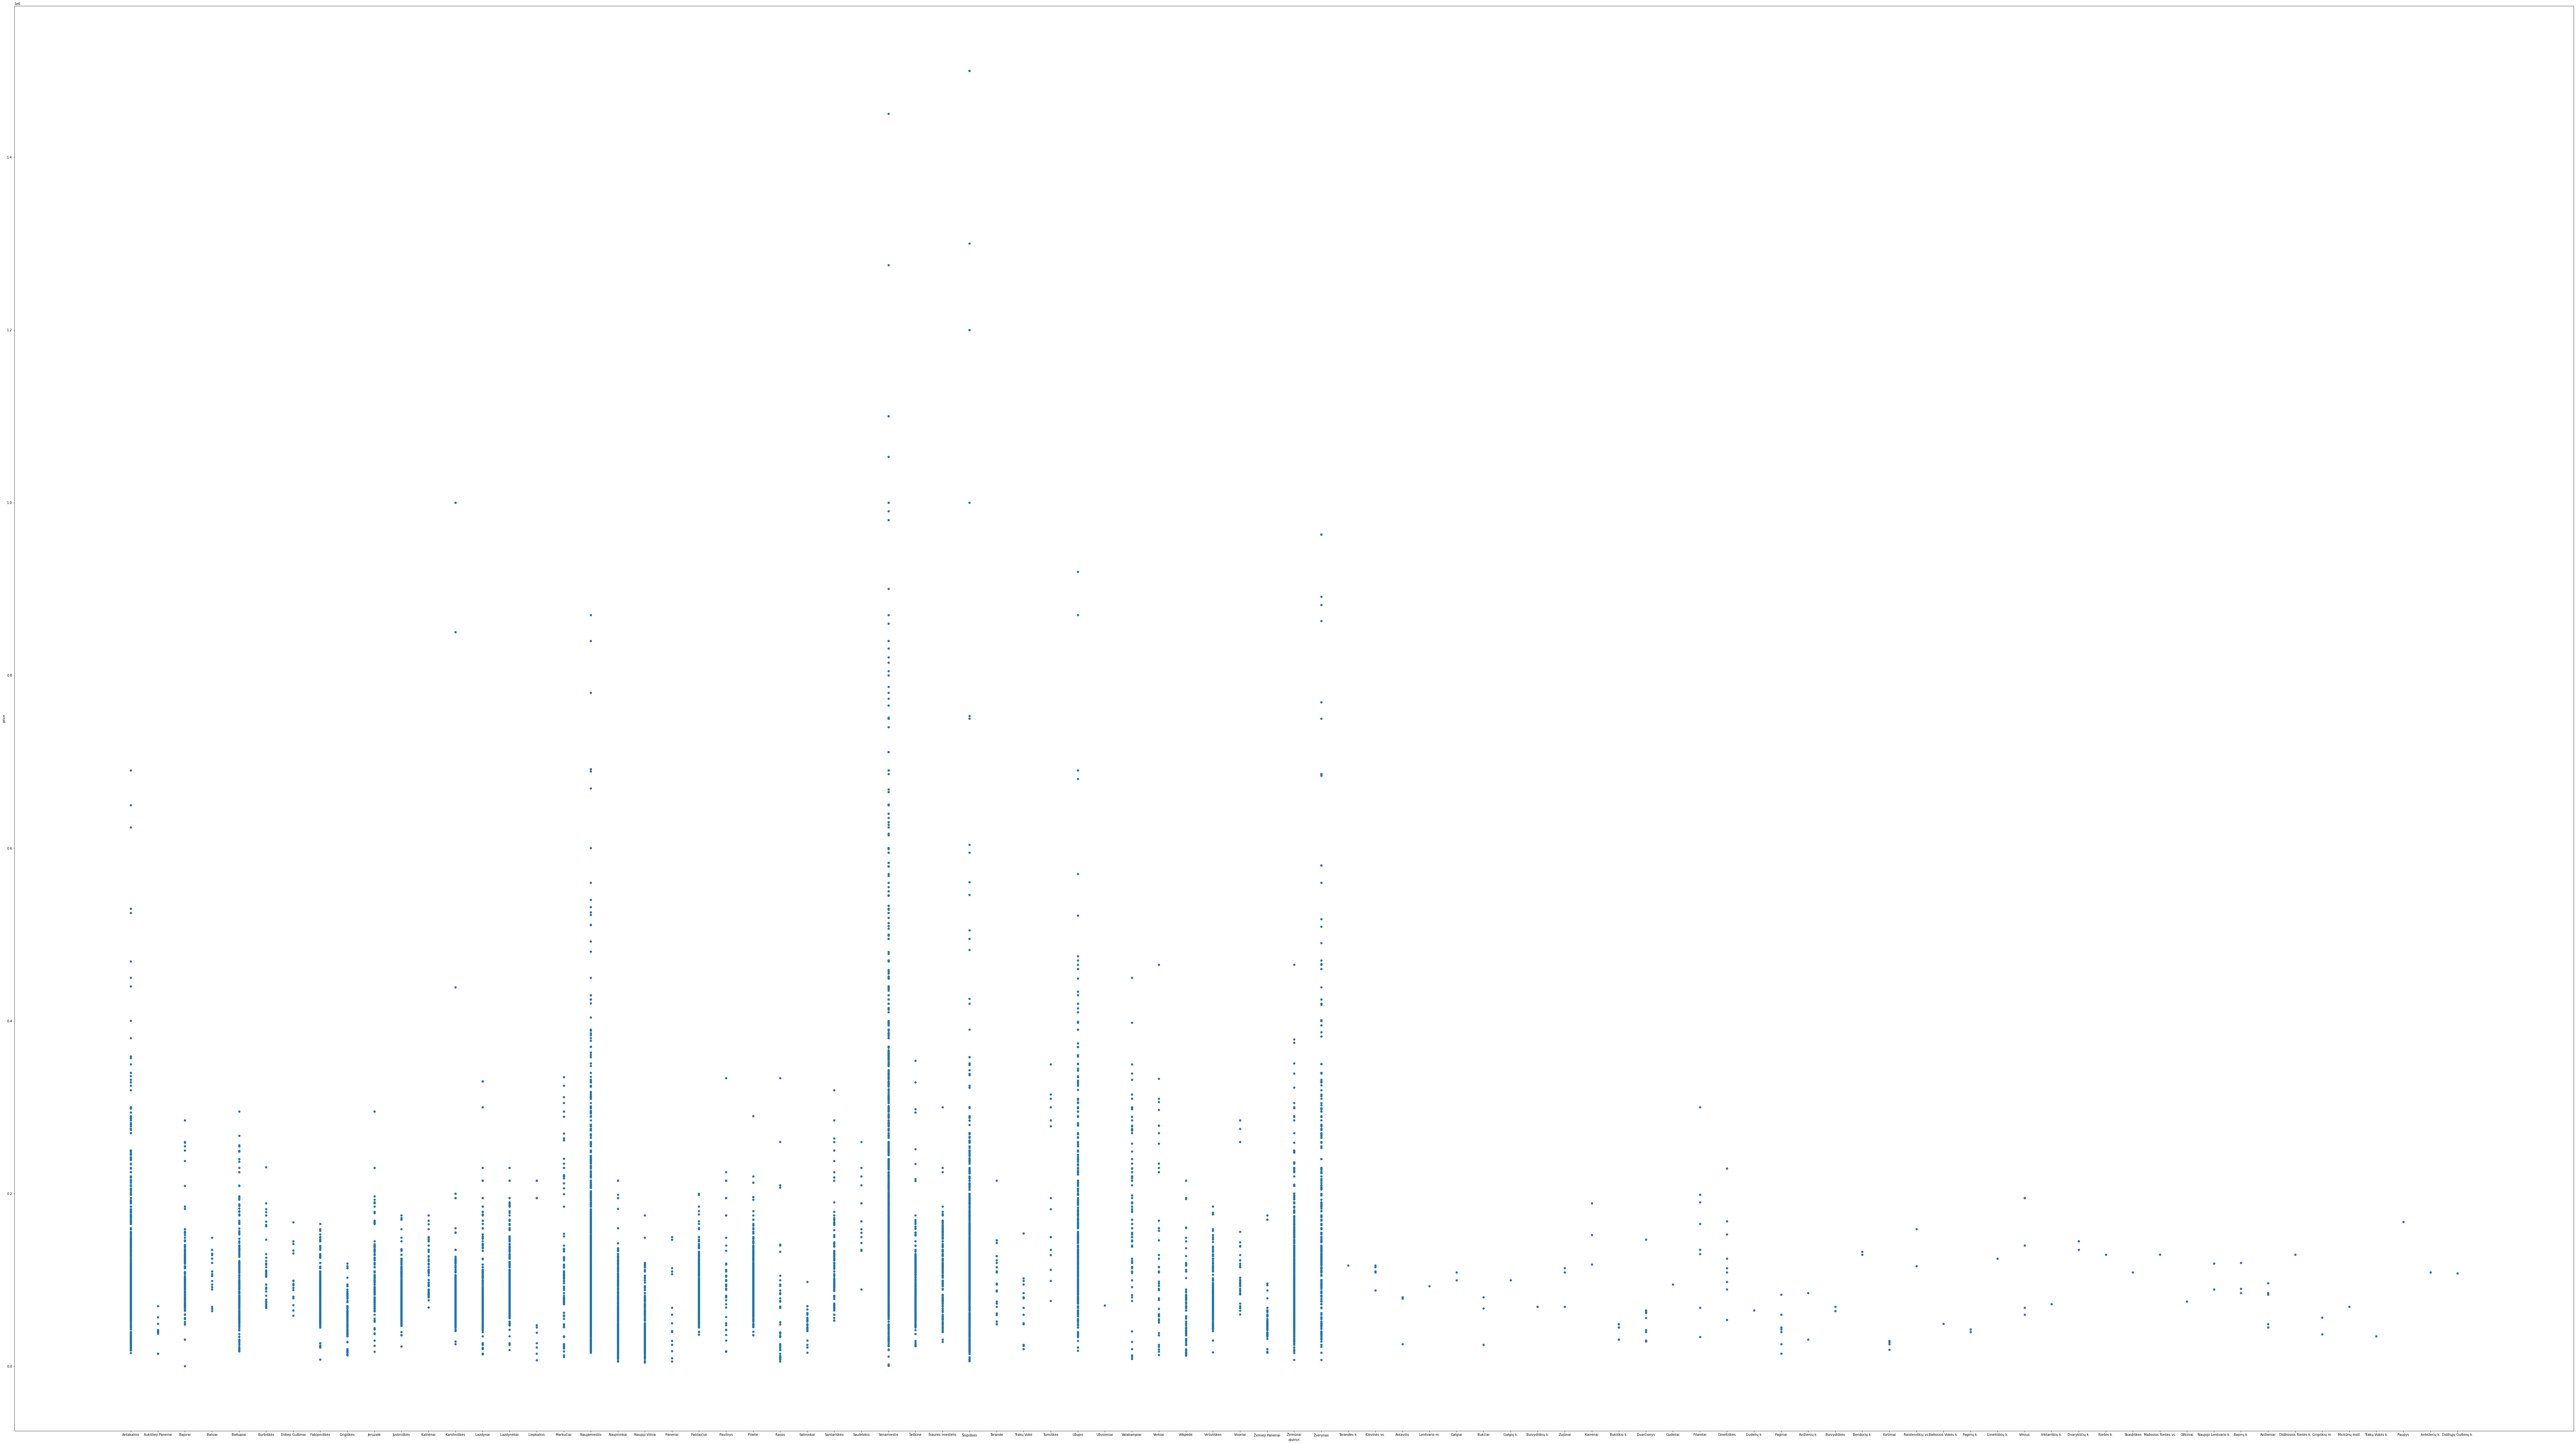

In [81]:
data1 = df.copy()
target_var = data['total_price']
target_var1 = data1['total_price']
plot2 = plt.figure(2)
plt.scatter(data['year'],target_var)
plt.xlabel('nr rooms')
plt.ylabel('price')
plot3 = plt.figure(3, figsize=(140, 80))
plt.scatter(data1['district'],target_var1)
plt.xlabel('district')
plt.ylabel('price')

# Function: Scorring, Importance

In [46]:
def rmse(x, y):
    return math.sqrt(((x - y) ** 2).mean())

def print_score(m):
    res = [
        rmse(m.predict(X_train), y_train),
        rmse(m.predict(X_valid), y_valid),
        m.score(X_train, y_train),
        m.score(X_valid, y_valid),
        mean_absolute_error(m.predict(X_valid), y_valid),
    ]
    if hasattr(m, "oob_score_"):
        res.append(m.oob_score_)
    print(res)

def feat_importance(m, df_train):
    importance = m.feature_importances_
    importance = pd.DataFrame(
        importance, index=df_train.columns, columns=["Importance"]
    )
    return importance.sort_values(by=["Importance"], ascending=False)

# **RandomForest**: 

In [74]:
mRF = RandomForestRegressor(
    n_estimators=800,
    min_samples_leaf=1,
    max_features=0.5,
    bootstrap=True,
    oob_score=True,
)  
mRF.fit(X_train, y_train)
print_score(mRF)

[0.06850033043242973, 0.20987104634127193, 0.9884515129505593, 0.8819842750766634, 0.14218865310235781, 0.9173453978941818]


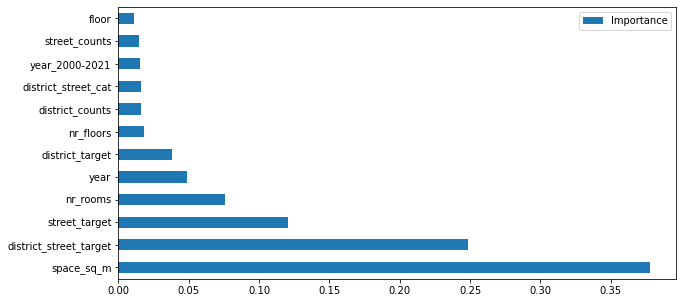

In [75]:
importance = feat_importance(mRF, X_train)
importance.plot(figsize=(10, 5), kind="barh")

In [76]:
y_pred_rf = mRF.predict(X_valid)

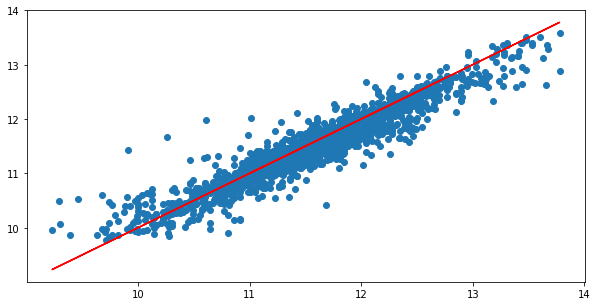

In [78]:
# Visualizing Our predictions
fig = plt.figure(figsize=(10, 5))
plt.scatter(y_valid, y_pred_rf)
# Perfect predictions
plt.plot(y_valid, y_valid, "r")

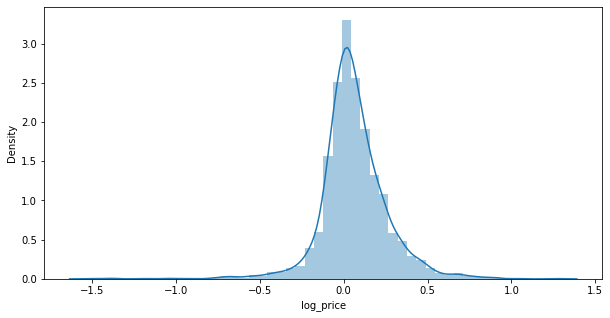

In [79]:
# visualizing residuals
fig = plt.figure(figsize=(10,5))
residuals = (y_valid - y_pred_rf)
sns.distplot(residuals)

In [80]:
scores = cross_val_score(mRF, X_train, y_train, cv=5, scoring="r2")
print(scores), print(scores.mean())

[0.89660281 0.90270778 0.90731473 0.91017582 0.89955183]
0.903270593597969


(None, None)

In [52]:
random_grid = {
    "n_estimators": [int(x) for x in np.arange(start=10, stop=1000, step=10)],
    "max_features": [0.5, "auto", "sqrt", "log2"],
    "min_samples_leaf": [1, 3, 5, 7, 10, 15, 25, 50, 100],
    "bootstrap": [True, False],
}
m = RandomForestRegressor()
m_random = RandomizedSearchCV(
    estimator=m,
    param_distributions=random_grid,
    n_iter=100,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
)
m_random.fit(X_train, y_train)
m_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 23.0min finished


{'bootstrap': True,
 'max_features': 0.5,
 'min_samples_leaf': 1,
 'n_estimators': 800}

# **Decision tree**

In [82]:
mDT = DecisionTreeRegressor(
    criterion="mse",
    max_features="auto",
    max_depth=25,
    max_leaf_nodes=100,
    min_samples_leaf=20,
    min_samples_split=40,
)
mDT.fit(X_train, y_train)
print_score(mDT)

[0.2256565944989878, 0.2627202107068312, 0.8746755468819221, 0.8150638592974959, 0.18860042589710918]


In [84]:
scores = cross_val_score(mDT, X_train, y_train, cv=5, scoring="r2")
print(scores), print(scores.mean())

[0.83143398 0.83811137 0.84693982 0.84348213 0.83529188]
0.8390518376303246


In [85]:
param_grid = {
    "criterion": ["mse", "mae"],
    "min_samples_split": [10, 20, 40, 60, 80],
    "max_depth": [2, 6, 8, 12, 16, 25],
    "min_samples_leaf": [20, 40, 100, 250, 500],
    "max_leaf_nodes": [5, 20, 100, 250, 500],
    "max_features": [0.5, "auto", "sqrt", "log2"],
}

m = DecisionTreeRegressor()
m = RandomizedSearchCV(
    estimator=m,
    param_distributions=param_grid,
    n_iter=100,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
)
m.fit(X_train, y_train)
m.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 206 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.1min finished


{'criterion': 'mae',
 'max_depth': 25,
 'max_features': 'auto',
 'max_leaf_nodes': 100,
 'min_samples_leaf': 20,
 'min_samples_split': 40}

# **XGBoost**: 

In [86]:
mXGB = XGBRegressor(
    reg_alpha=0.25,
    reg_lambda=1.0,
    gamma=0.0,
    colsample_bytree=1.0,
    colsample_bylevel=0.4,
    n_estimators=170,
    min_child_weight=7.0,
    max_depth=15,
    subsample=0.7,
    learning_rate=0.1,
)

mXGB.fit(X_train, y_train)
print_score(mXGB)

[20:51:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 2.5 s, sys: 25.9 ms, total: 2.52 s
Wall time: 2.66 s
[0.08003217218720375, 0.2068872339619831, 0.98423590775142, 0.8853161644367817, 0.1400999379117384]


In [87]:
scores = cross_val_score(mXGB, X_train, y_train, cv=5, scoring="r2")
print(scores), print(scores.mean())

[20:54:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:54:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:54:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:54:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:54:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.9081774  0.90372417 0.91379185 0.91319688 0.9067341 ]
0.9091248798159965


(None, None)

In [ ]:
random_grid = {
    "n_estimators": [int(x) for x in np.arange(start=10, stop=1000, step=10)],
    "max_depth": [1, 3, 6, 10, 15, 20, 50, 75, 100],
    "reg_lambda": [0.1, 0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0],
    "reg_alpha": [0.1, 0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0],
    "colsample_bytree": [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bylevel": [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    "learning_rate": [0.01, 0.1, 0.2, 0.3, 0.5],
    "gamma": [0, 0.25, 0.5, 1.0],
    "subsample": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    "min_child_weight": [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
}

# First create the base model to tune
m = XGBRegressor()
# Fit the random search model
m_random = RandomizedSearchCV(
    estimator=m,
    param_distributions=random_grid,
    n_iter=100,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
)
m_random.fit(X_train, y_train)
m_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 11.2min finished


[15:05:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'colsample_bylevel': 0.4,
 'colsample_bytree': 1.0,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 15,
 'min_child_weight': 7.0,
 'n_estimators': 170,
 'reg_alpha': 0.25,
 'reg_lambda': 1.0,
 'subsample': 0.7}

# **LightGBM**: 
https://www.kaggle.com/lasmith/house-price-regression-with-lightgbm

In [88]:
gbm = lgb.LGBMRegressor(
    bagging_fraction=0.7,
    bagging_freq=15,
    boosting_type="gbdt",
    feature_fraction=0.7,
    learning_rate=0.1,
    max_bin=250,
    max_depth=180,
    min_data=60,
    n_estimators=290,
    num_leaves=230,
    sub_feature=0.5,
)

gbm.fit(X_train, y_train)
print_score(gbm)

CPU times: user 1.47 s, sys: 56.8 ms, total: 1.53 s
Wall time: 1.57 s
[0.11934764664891022, 0.20642053190486112, 0.9649435868619322, 0.8858329948994491, 0.14399153072182824]


In [89]:
scores = cross_val_score(gbm, X_train, y_train, cv=5, scoring="r2")
print(scores), print(scores.mean())

[0.90662039 0.90685438 0.90312345 0.90690253 0.89673264]
0.9040466776097915


(None, None)

In [ ]:
random_grid = {
    "learning_rate": [0.01, 0.1, 0.2, 0.3, 0.5],
    "boosting_type": ["gbdt", "dart", "goss"],
    "sub_feature": [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    "num_leaves": [int(x) for x in np.arange(start=10, stop=300, step=10)],
    "min_data": [int(x) for x in np.arange(start=10, stop=100, step=10)],
    "max_depth": [int(x) for x in np.arange(start=5, stop=200, step=5)],
    "feature_fraction": [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    "bagging_fraction": [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    "bagging_freq": [1, 2, 4, 6, 8, 10, 15],
    "max_bin": [int(x) for x in np.arange(start=50, stop=1000, step=50)],
    #'num_iterations': [int(x) for x in np.arange(start = 10000, stop = 100000, step = 10000)],
    "n_estimators": [int(x) for x in np.arange(start=10, stop=500, step=10)],
}

m = lgb.LGBMRegressor()
m_random = RandomizedSearchCV(
    estimator=m,
    param_distributions=random_grid,
    n_iter=100,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
)
m_random.fit(X_train, y_train)
m_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.0min finished


{'bagging_fraction': 0.7,
 'bagging_freq': 15,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.7,
 'learning_rate': 0.1,
 'max_bin': 250,
 'max_depth': 180,
 'min_data': 60,
 'n_estimators': 290,
 'num_leaves': 230,
 'sub_feature': 0.5}

# **Linear Regression, Ridge, Lasso, ElasticNet**

In [90]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train)
print_score(regressor)

[0.2696265020828218, 0.2915975309884051, 0.8210775180654882, 0.772174407857688, 0.21127960350603167]


In [91]:
y_pred = regressor.predict(X_valid)

In [ ]:
print('MAE:', metrics.mean_absolute_error(y_valid, y_pred))  
print('MSE:', metrics.mean_squared_error(y_valid, y_pred))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, y_pred)))
print('VarScore:',metrics.explained_variance_score(y_valid,y_pred))

MAE: 0.2059318590842473
MSE: 0.08172260057459585
RMSE: 0.28587165052623853
VarScore: 0.8035539265826748


In [92]:
scores = cross_val_score(regressor, X_train, y_train, cv=5, scoring="r2")
print(scores), print(scores.mean())

[0.82285554 0.82081786 0.81029388 0.81006771 0.80946966]
0.814700928255634


(None, None)

In [94]:
from sklearn.linear_model import Ridge
my_alpha = 0.25
my_model = Ridge(alpha = my_alpha)
my_model.fit(X_train, y_train)
print_score(my_model)

[0.26962650549845224, 0.2915924498237459, 0.8210775135323058, 0.7721823476317832, 0.21127636418924423]


In [95]:
scores = cross_val_score(my_model, X_train, y_train, cv=5, scoring="r2")
print(scores), print(scores.mean())

[0.82285186 0.82082352 0.8103     0.81006454 0.80947224]
0.8147024319762979


(None, None)

In [96]:
from sklearn.linear_model import Lasso
my_alpha = 0.0001
my_model = Lasso(alpha = my_alpha)
my_model.fit(X_train, y_train)
print_score(my_model)

[0.26962705830376804, 0.2915807136184223, 0.8210767798551569, 0.7722006859731185, 0.2112533993814242]


In [97]:
scores = cross_val_score(my_model, X_train, y_train, cv=5, scoring="r2")
print(scores), print(scores.mean())

[0.82280563 0.82086016 0.81030791 0.81004833 0.80950015]
0.8147044374241414


(None, None)

In [98]:
from sklearn.linear_model import ElasticNet
my_alpha = 0.01
my_l1ratio = 0.05
my_model = ElasticNet(alpha=my_alpha, l1_ratio=my_l1ratio)
my_model.fit(X_train, y_train)
print_score(my_model)

[0.2699580382683659, 0.29054759268525987, 0.8206372368128677, 0.7738120909544632, 0.21051156313438132]


In [99]:
scores = cross_val_score(my_model, X_train, y_train, cv=5, scoring="r2")
print(scores), print(scores.mean())

[0.821507   0.82172191 0.81067576 0.80891035 0.80972873]
0.8145087501343324


(None, None)

# **Neural Network**
https://towardsdatascience.com/house-prices-prediction-using-deep-learning-dea265cc3154

In [104]:
s_scaler = StandardScaler()
X_train_nn = s_scaler.fit_transform(X_train.astype(np.float))
X_valid_nn = s_scaler.transform(X_valid.astype(np.float))

In [105]:
def re_pred_nn():
  re_model = Sequential()
  re_model.add(Dense(12,activation='relu'))
  re_model.add(Dense(12,activation='relu'))
  re_model.add(Dense(12,activation='relu'))
  re_model.add(Dense(12,activation='relu'))
  re_model.add(Dense(1))
  re_model.compile(loss='mse', optimizer='rmsprop')
  return re_model

In [ ]:
model = re_pred_nn()
model.fit(
    x=X_train_nn,
    y=y_train,
    validation_data=(X_valid_nn, y_valid),
    batch_size=32,
    epochs=100,
)
model.summary()

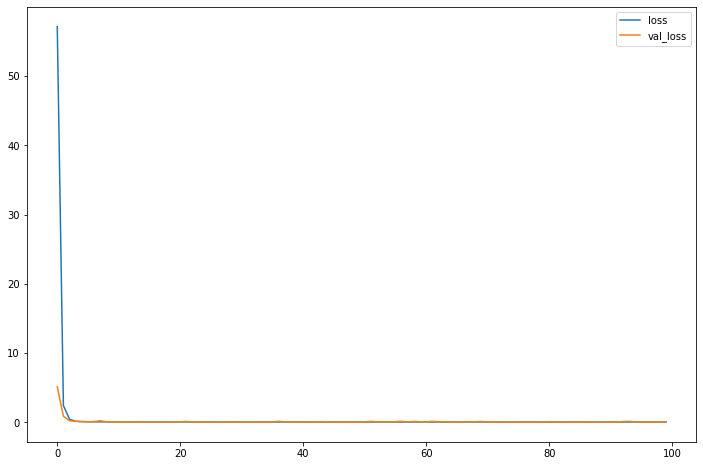

In [108]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot(figsize=(12,8))

In [112]:
y_pred = model.predict(X_valid_nn)

print('MAE:', metrics.mean_absolute_error(y_valid, y_pred))   
print('MSE:', metrics.mean_squared_error(y_valid, y_pred))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, y_pred)))
print('VarScore:', metrics.explained_variance_score(y_valid, y_pred))

MAE: 0.22864396874548043
MSE: 0.08600203072943316
RMSE: 0.29326102831681056
VarScore: 0.8501061697408572


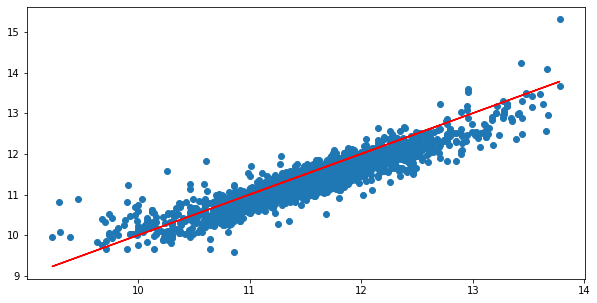

In [110]:
# Visualizing Our predictions
fig = plt.figure(figsize=(10, 5))
plt.scatter(y_valid, y_pred)
# Perfect predictions
plt.plot(y_valid, y_valid,'r')

In [111]:
# FOR HYPER PARAMETER TUNING
def re_pred_nn_HYPER_PARAM(optimizer=''):
  re_model = Sequential()
  re_model.add(Dense(12,activation='relu'))
  re_model.add(Dense(12,activation='relu'))
  re_model.add(Dense(12,activation='relu'))
  re_model.add(Dense(12,activation='relu'))
  re_model.add(Dense(1))
  re_model.compile(loss='binary_crossentropy',  metrics=['acc', 'mae'])
  return re_model

In [ ]:
nn = KerasRegressor(build_fn=re_pred_nn_HYPER_PARAM, verbose=1)

hyperparameters = dict(
    epochs=[5, 10, 25, 50, 100, 150],
    batch_size=[16, 32, 64, 128],
    optimizer=["sgd", "adam", "Nadam", "rmsprop"],
)

grid = RandomizedSearchCV(
    estimator=nn, param_distributions=hyperparameters, cv=2
)  # , n_iter = 100, verbose=2, random_state=42, n_jobs = -1)

grid_result = grid.fit(X_train_nn, y_train)
print()
print(grid_result.best_params_)